<a href="https://colab.research.google.com/github/RyanSmoak/iPrevent/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from imblearn.over_sampling import SMOTE

In [ ]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    df = pd.read_csv(file_path)
    return df

In [ ]:
def perform_eda(df, dataset_name=""):
    """Perform exploratory data analysis on the dataset."""
    # Basic dataset overview
    print(f"{dataset_name} First 5 Rows of Data Set:\n", df.head())
    print(f"\n{dataset_name} Information about the Data Set:\n", df.info())
    print(f"\n{dataset_name} Missing Values in the Data Set:\n", df.isnull().sum())
    print(f"\n{dataset_name} Basic Statistics:\n", df.describe())

    # Distribution of categorical variables
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for column in categorical_columns:
        plt.figure(figsize=(15, 10))
        sns.countplot(data=df, x=column)
        plt.title(f'{dataset_name} Distribution of {column}')
        plt.show()

    # Distribution of numerical variables
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns].hist(bins=15, figsize=(20, 15))
    plt.suptitle(f'{dataset_name} Distribution of numerical variables')
    plt.show()

    # Correlation matrix (DoctorInCharge column removed if present)
    if 'DoctorInCharge' in df.columns:
        df_corr = df.drop(columns=['DoctorInCharge'])
    else:
        df_corr = df.copy()
    plt.figure(figsize=(15, 10))
    sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
    plt.title(f'{dataset_name} Correlation Matrix')
    plt.show()

In [ ]:
def handle_missing_values(df, strategy='mean'):
    """Handle missing values in numerical columns using the specified strategy (mean, median, most_frequent)."""
    imputer = SimpleImputer(strategy=strategy)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

    # Optionally handle categorical columns (e.g., with 'most_frequent')
    categorical_columns = df.select_dtypes(include=['object']).columns
    if not categorical_columns.empty:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])
    return df

In [ ]:
def encode_categorical_values(df, drop_first=True):
    """One-hot encode categorical variables. Can drop the first category to avoid multi-collinearity."""
    categorical_columns = df.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, drop='first' if drop_first else None)
    encoded_columns = pd.DataFrame(encoder.fit_transform(df[categorical_columns]),
                                   columns=encoder.get_feature_names_out(categorical_columns),
                                   index=df.index)  # Ensure matching index

    # Drop original categorical columns and concatenate the encoded columns
    df = df.drop(categorical_columns, axis=1)
    df = df.drop('PatientID', axis=1)
    df = pd.concat([df, encoded_columns], axis=1)
    return df

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Creating new features
def create_new_features(df):
    # For example, we can add the product of age and BMI as a new feature
    df['Age_BMI'] = df['Age'] * df['BMI']
    return df


# Creating Polynomial Features
def add_polynomial_features(df, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    poly_features = poly.fit_transform(df[numeric_columns])
    poly_feature_names = poly.get_feature_names_out(numeric_columns)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

    df = df.reset_index(drop=True)
    poly_df = poly_df.reset_index(drop=True)

    df = pd.concat([df, poly_df], axis=1)
    return df

In [ ]:
def normalize_data(df):
    """Normalize numerical columns using StandardScaler (zero mean, unit variance)."""
    scaler = StandardScaler()
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

In [ ]:
def split_data(df, target_column, test_size=0.2, random_state=42):
    """Split the data into training and testing sets."""
    # Separate the features (X) and the target variable (y)
    X = df.drop(target_column, axis=1)  # Dropping the target column to get features
    y = df[target_column]  # Target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test  # Returning the split datasets

In [ ]:
def save_datasets(X_train, X_test, y_train, y_test, X_cv, y_cv, output_dir):
    """Save training and testing sets to CSV files."""
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save training and testing sets to CSV files
    X_train.to_csv(os.path.join(output_dir, 'X_train.csv'), index=False)
    X_test.to_csv(os.path.join(output_dir, 'X_test.csv'), index=False)
    y_train.to_csv(os.path.join(output_dir, 'y_train.csv'), index=False)
    y_test.to_csv(os.path.join(output_dir, 'y_test.csv'), index=False)
    X_cv.to_csv(os.path.join(output_dir, 'X_cv.csv'), index=False)
    y_cv.to_csv(os.path.join(output_dir, 'y_cv.csv'), index=False)

    # Print confirmation message
    print(f"Datasets saved to {output_dir}")

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def main(data, target_column, output_dir):
    """Main function to run the data processing pipeline."""

    df = create_new_features(data)
    df = add_polynomial_features(data, 5)

    df = data.drop(columns=['Diagnosis'])
    df_target = data['Diagnosis']
    #perform_eda(df, dataset_name="Original")
    df = handle_missing_values(df)
    df = encode_categorical_values(df)
    df = normalize_data(df)

    df['Diagnosis'] = pd.Series(data['Diagnosis'])

    # Splitting data into training and testing sets
    X_train, X_temp, y_train, y_temp = split_data(df, target_column, random_state=42)

    # Splitting the temporary set into cross-validation and testing sets
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    save_datasets(X_train, X_test, y_train, y_test, X_cv, y_cv, output_dir)


    # Oversample the training, test and cv set
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_test, y_test = smote.fit_resample(X_test, y_test)
    X_cv, y_cv = smote.fit_resample(X_cv, y_cv)



    # Column analysis for training, cross-validation, and test sets
    #perform_eda(pd.concat([X_train, y_train], axis=1), dataset_name="Training Set")
    #perform_eda(pd.concat([X_test, y_test], axis=1), dataset_name="Test Set")
    #perform_eda(pd.concat([X_cv, y_cv], axis=1), dataset_name="Cross Validation Set")

    return X_train, X_test, y_train, y_test, X_cv, y_cv

In [ ]:
#connect to drive and get data from drive
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/KamiLimu/iPrevent/diabetes_data.csv',
                   index_col= None,
                   header = 0,)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PatientID,Age,Gender,SocioeconomicStatus,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,AntihypertensiveMedications,AntidiabeticMedications,FrequentUrination,ExcessiveThirst,UnexplainedWeightLoss,FatigueLevels,BlurredVision,SlowHealingSores,TinglingHandsFeet,Diagnosis
0,6000,44,0,2,32.985284,1,4.499365,2.443385,4.898831,4.049885,...,0,1,0,0,0,9.534169,0,0,1,1
1,6001,51,1,1,39.916764,0,1.578919,8.301264,8.941093,7.508150,...,0,0,0,0,0,0.123214,0,0,0,1
2,6002,89,1,1,19.782251,0,1.177301,6.103395,7.722543,7.708387,...,1,0,0,0,0,9.643320,0,0,0,0
3,6003,21,1,1,32.376881,1,1.714621,8.645465,4.804044,6.286548,...,0,1,0,0,0,3.403557,0,0,0,0
4,6004,27,1,1,16.808600,0,15.462549,4.629383,2.532756,9.771125,...,1,0,0,0,0,2.924687,0,0,0,0


In [ ]:
print(data['Diagnosis'].dtype)

print(data['Diagnosis'].unique())

int64
[1 0]


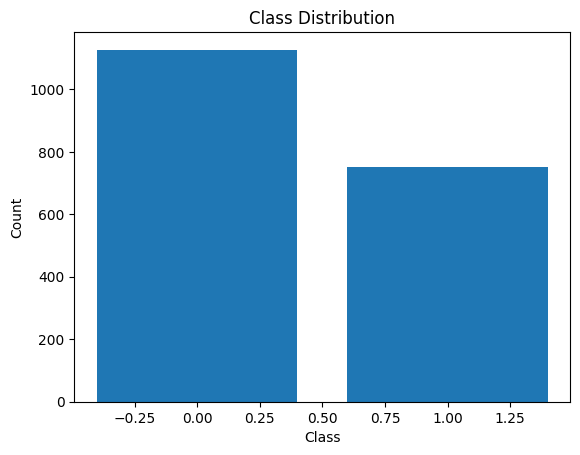

In [ ]:
x=data.drop(["Diagnosis"],axis=1)
y=data["Diagnosis"]

count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [ ]:
#find unique values in a column
data["Diagnosis"].unique()

array([1, 0])

In [ ]:
if __name__ == "__main__":
    target_column = "Diagnosis"  # Target variable
    output_dir = r"/content/drive/MyDrive/KamiLimu/iPrevent"  # Directory to save
    X_train, X_test, y_train, y_test, X_cv, y_cv = main(data, target_column, output_dir)

Datasets saved to /content/drive/MyDrive/KamiLimu/iPrevent


## Model Training

In [ ]:
#importing libraries needed for the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#create an instance of the classifier with default parameters
clf = RandomForestClassifier(random_state=42,
                             bootstrap= False,
                             max_depth=30,
                             max_features = 'sqrt',
                             min_samples_leaf= 1, min_samples_split = 2,
                             n_estimators= 200)

#fit the model
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_

# Create a DataFrame
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Sort by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

print(importances_df)

#make predictions on the test set
y_pred = clf.predict(X_cv)

#calculate accuracy, precision_recall, f1_score
accuracy = accuracy_score(y_cv, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_cv, y_pred, average='weighted')
print("Precision:", precision)
recall = recall_score(y_cv, y_pred, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_cv, y_pred, average='weighted')
print("F1 Score:", f1)

                        feature  importance
7                   DietQuality    0.094534
22                      Age_BMI    0.094395
8                  SleepQuality    0.092410
6              PhysicalActivity    0.091132
18                FatigueLevels    0.090856
3                           BMI    0.090121
5            AlcoholConsumption    0.089768
0                           Age    0.081185
2           SocioeconomicStatus    0.043627
15            FrequentUrination    0.027491
12                 Hypertension    0.023612
1                        Gender    0.021654
4                       Smoking    0.021199
9         FamilyHistoryDiabetes    0.018079
16              ExcessiveThirst    0.017753
13  AntihypertensiveMedications    0.017711
14      AntidiabeticMedications    0.017160
11          PreviousPreDiabetes    0.013895
21            TinglingHandsFeet    0.011756
17        UnexplainedWeightLoss    0.011591
19                BlurredVision    0.010494
10          GestationalDiabetes 

In [ ]:
#import libraries for XGBoost and stacking
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
#create an instance of the xgboost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',random_state=42)

#fit the model
xgb.fit(X_train, y_train)

#make prediction on the test set
y_pred_xgb = xgb.predict(X_test)

#calculate accuracy, precision_recall, f1_score
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5714285714285714


In [ ]:
#import gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

#create an instance of the gradient boosting classifier
gbm = GradientBoostingClassifier(subsample=0.7, n_estimators=900,
                                 min_samples_leaf= 2,
                                 min_impurity_decrease=0.05,
                                 max_features='sqrt', max_depth=7,
                                 loss='exponential',
                                 learning_rate=0.01,
                                 criterion='friedman_mse')

#fit the model
gbm.fit(X_train, y_train)

#make prediction on the test set
y_pred_gbm = gbm.predict(X_cv)

#calculate accuracy, precision_recall, f1
accuracy = accuracy_score(y_cv, y_pred_gbm)
print("Accuracy:", accuracy)

Accuracy: 0.6694214876033058


## Model tuning
Since we've gotten pretty bad initial results, let's tune the mdoel a bit


In [ ]:
#import gridsearchcv
from sklearn.model_selection import GridSearchCV

#create parameter grid for searching
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


#create an object of gridsearchcv
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

#fit the model
grid_search.fit(X_train, y_train)

print(f"Best parameters include: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2700 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1311 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

Best parameters include: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.6958437006087351


In [ ]:
#import randomizedsearchcv
from sklearn.model_selection import RandomizedSearchCV as RCV
import numpy as np

#create parameter dist for searching
param_grid = {
    'n_estimators': np.arange(50, 200, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.linspace(0, 0.5, 10)
}

#create an object of rcv
random_search = RCV(estimator=xgb,
                    param_distributions=param_grid,
                    n_iter = 100, cv=5,
                    random_state= 42, n_jobs=-1)

#fit the model
random_search.fit(X_train, y_train)

print(f"Best parameters include: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters include: {'subsample': 0.9444444444444444, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1711111111111111, 'gamma': 0.16666666666666666, 'colsample_bytree': 0.5555555555555556}
Best score: 0.6527518269877783


In [ ]:
#import randomizedsearchcv
from sklearn.model_selection import RandomizedSearchCV as RCV
import numpy as np

#create parameter dist for searching
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.05, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'loss': ['deviance', 'exponential'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]
}

#create an object of rcv
random_search = RCV(estimator=gbm,
                    param_distributions=param_dist,
                    n_iter = 100, cv=5,
                    random_state= 42, n_jobs=-1)

#fit the model
random_search.fit(X_train, y_train)

print(f"Best parameters include: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
415 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best parameters include: {'subsample': 0.7, 'n_estimators': 900, 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.05, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'exponential', 'learning_rate': 0.01, 'criterion': 'friedman_mse'}
Best score: 0.6639578736522541


## Ensemble learning

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression as LR

estimators = [
    ('gbm', gbm),
    ('rf', clf)
]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LR())

stacked_model.fit(X_train, y_train)

predictions = stacked_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6116071428571429
